In [2]:
# Cell 1: Imports & Paths

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd

DATA_DIR = Path("D:/Projects/DPL 2025")

# Core macro / controls
CORE = DATA_DIR / "Core_economic_indicators.csv"
RESIL = DATA_DIR / "Resilience.csv"
SOC  = DATA_DIR / "Social_and_welfare.csv"
DIS  = DATA_DIR / "disasters.csv"
POP  = DATA_DIR / "population_and_demographics.csv"

# Trade (two periods each)
IMP_FILES = [
    DATA_DIR / "2000-2012_Import.csv",
    DATA_DIR / "2013-2024_Import.csv",
]
EXP_FILES = [
    DATA_DIR / "2000-2012_Export.csv",
    DATA_DIR / "2013-2024_Export.csv",
]


In [3]:
# Cell 2: Safe CSV reading with encoding fallback

def read_csv_safely(path: Path, **kwargs) -> pd.DataFrame:
    if not path.exists():
        print(f"[WARN] Missing file: {path.name}. Returning empty DataFrame.")
        return pd.DataFrame()
    try:
        return pd.read_csv(path, encoding="utf-8", **kwargs)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin1", **kwargs)
    except Exception as e:
        print(f"[WARN] Could not read {path.name}: {e}")
        return pd.DataFrame()

def read_many(paths, **kwargs) -> pd.DataFrame:
    dfs = [read_csv_safely(p, **kwargs) for p in paths]
    dfs = [d for d in dfs if not d.empty]
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [4]:
# Cell 3: Load Data

core = read_csv_safely(CORE)
resil = read_csv_safely(RESIL)
soc  = read_csv_safely(SOC)
dis  = read_csv_safely(DIS, low_memory=False)
pop  = read_csv_safely(POP, low_memory=False)

imp_raw = read_many(IMP_FILES, low_memory=False)
exp_raw = read_many(EXP_FILES, low_memory=False)

print("Core:", core.shape)
print("Resilience:", resil.shape)
print("Social:", soc.shape)
print("Disasters:", dis.shape)
print("Population:", pop.shape)
print("Imports:", imp_raw.shape)
print("Exports:", exp_raw.shape)


Core: (180, 29)
Resilience: (80, 29)
Social: (205, 29)
Disasters: (3613, 46)
Population: (3000, 15)
Imports: (93684, 47)
Exports: (83814, 47)


In [5]:
from pathlib import Path

files = list(Path(DATA_DIR).glob("*"))
print("All files in DATA_DIR:", [f.name for f in files])


All files in DATA_DIR: ['2000-2012_Export.csv', '2000-2012_Import.csv', '2013-2024_Export.csv', '2013-2024_Import.csv', 'ageing_risk_top10.png', 'Core_economic_indicators.csv', 'crop_and_livestock.csv', 'disasters.csv', 'DPL Demonstration.mp4', 'dpl-voice_over.mp3', 'DPL_ProblemStatement.docx', 'Employment_Unemployment.csv', 'global_trade_network.png', 'population_and_demographics.csv', 'Resilience.csv', 'Social_and_welfare.csv', 'task1.ipynb', 'task1_final.ipynb', 'task2.ipynb', 'task5.ipynb', 'tasks6_7.ipynb', 'Team_Details.txt']


In [6]:
# Match your actual import/export files
IMP_FILES = list(Path(DATA_DIR).glob("*_Import.csv"))
EXP_FILES = list(Path(DATA_DIR).glob("*_Export.csv"))

print("Import files found:", [f.name for f in IMP_FILES])
print("Export files found:", [f.name for f in EXP_FILES])


# If no files found, nothing else will work
if not IMP_FILES:
    raise FileNotFoundError("No import files found. Check your file names or DATA_DIR.")
if not EXP_FILES:
    raise FileNotFoundError("No export files found. Check your file names or DATA_DIR.")

# Read raw imports
imp_raw = read_many(IMP_FILES)
print("Raw Imports shape:", imp_raw.shape)
print("Raw Imports sample:\n", imp_raw.head())

# Read raw exports
exp_raw = read_many(EXP_FILES)
print("Raw Exports shape:", exp_raw.shape)
print("Raw Exports sample:\n", exp_raw.head())


Import files found: ['2000-2012_Import.csv', '2013-2024_Import.csv']
Export files found: ['2000-2012_Export.csv', '2013-2024_Export.csv']
Raw Imports shape: (93684, 47)
Raw Imports sample:
   typeCode  freqCode  refPeriodId  refYear  refMonth  period reporterCode  \
0        A  20000101         2000       52      2000       8          ALB   
1        A  20000101         2000       52      2000       8          ALB   
2        A  20000101         2000       52      2000       8          ALB   
3        A  20000101         2000       52      2000       8          ALB   
4        A  20000101         2000       52      2000       8          ALB   

  reporterISO reporterDesc flowCode  ...  netWgt isNetWgtEstimated grossWgt  \
0     Albania            M   Import  ...   False               NaN    False   
1     Albania            M   Import  ...   False               NaN    False   
2     Albania            M   Import  ...   False               NaN    False   
3     Albania            M   Im

In [7]:
def clean_trade(df, kind):
    """Clean raw trade dataset and extract relevant columns."""

    # Pick correct value column
    if kind == "Imports":
        value_col = "cifvalue" if "cifvalue" in df.columns else "primaryValue"
    else:
        value_col = "fobvalue" if "fobvalue" in df.columns else "primaryValue"

    # Keep only useful columns
    df = df.rename(columns={
        "reporterISO": "Country",
        "partnerISO": "Partner",
        "refPeriodId": "Year",   # <-- FIXED here
        value_col: "Value"
    })[["Country", "Partner", "Year", "Value"]]

    # Drop null or zero values
    df = df.dropna(subset=["Value"])
    df = df[df["Value"] > 0]

    # Compute partner share (for imports only)
    if kind == "Imports":
        df["Share"] = df.groupby(["Country", "Year"])["Value"].transform(
            lambda x: x / x.sum()
        )

    return df



imp_raw = read_many(IMP_FILES)
imp = clean_trade(imp_raw, kind="Imports")

exp_raw = read_many(EXP_FILES)
exp = clean_trade(exp_raw, kind="Exports")

print("Imports sample:\n", imp.head())
print("Exports sample:\n", exp.head())


Imports sample:
        Country      Partner  Year        Value         Share
135  Australia  Afghanistan  2000      32847.0  7.165176e-07
136  Australia    Argentina  2000   57636915.0  1.257280e-03
137  Australia    Australia  2000  288391032.0  6.290902e-03
138  Australia   Bangladesh  2000   46428416.0  1.012780e-03
139  Australia      Belgium  2000  484826177.0  1.057590e-02
Exports sample:
    Country      Partner  Year     Value
0  Albania  Afghanistan  2000     209.0
1  Albania    Australia  2000   22288.0
2  Albania      Belgium  2000  266645.0
3  Albania       Canada  2000     390.0
4  Albania        China  2000    1013.0


In [8]:
# Cell 6: Compute Trade Dependency Index (TDI)

def compute_tdi(trade_df: pd.DataFrame) -> pd.DataFrame:
    if trade_df.empty:
        return pd.DataFrame()
    
    # Share per partner
    trade_df["Share"] = trade_df.groupby(["Country","Year"])["Value"].transform(lambda x: x / x.sum())
    
    # Herfindahl Index (sum of squared shares)
    hhi = trade_df.groupby(["Country","Year"])["Share"].apply(lambda s: (s**2).sum()).reset_index()
    hhi = hhi.rename(columns={"Share":"HHI"})
    
    # Exposure = total imports / GDP (merge later)
    exposure = trade_df.groupby(["Country","Year"])["Value"].sum().reset_index()
    exposure = exposure.rename(columns={"Value":"ImportTotal"})
    
    tdi = hhi.merge(exposure, on=["Country","Year"], how="left")
    return tdi

tdi = compute_tdi(imp)
print("TDI sample:")
print(tdi.head())


TDI sample:
  Country  Year       HHI   ImportTotal
0  Angola  2004  0.139455  2.538542e+09
1  Angola  2005  0.125707  3.697905e+09
2  Angola  2006  0.127339  6.370395e+09
3  Angola  2008  0.128133  1.239484e+10
4  Angola  2015  0.159178  1.129849e+10


In [9]:
# List all variables in memory
print([v for v in globals().keys() if not v.startswith("_")])


['In', 'Out', 'get_ipython', 'exit', 'quit', 'open', 'plt', 'warnings', 'Path', 'np', 'pd', 'DATA_DIR', 'CORE', 'RESIL', 'SOC', 'DIS', 'POP', 'IMP_FILES', 'EXP_FILES', 'read_csv_safely', 'read_many', 'core', 'resil', 'soc', 'dis', 'pop', 'imp_raw', 'exp_raw', 'files', 'clean_trade', 'imp', 'exp', 'compute_tdi', 'tdi']


In [10]:
# Debug Imports (clean)
print("Imports (clean) columns:", imp.columns.tolist())
print("\nSample Imports rows:")
print(imp.head(10))

# Debug Exports (clean)
print("\nExports (clean) columns:", exp.columns.tolist())
print("\nSample Exports rows:")
print(exp.head(10))


Imports (clean) columns: ['Country', 'Partner', 'Year', 'Value', 'Share']

Sample Imports rows:
       Country      Partner  Year         Value         Share
135  Australia  Afghanistan  2000  3.284700e+04  7.165176e-07
136  Australia    Argentina  2000  5.763692e+07  1.257280e-03
137  Australia    Australia  2000  2.883910e+08  6.290902e-03
138  Australia   Bangladesh  2000  4.642842e+07  1.012780e-03
139  Australia      Belgium  2000  4.848262e+08  1.057590e-02
140  Australia       Canada  2000  1.170331e+09  2.552935e-02
141  Australia    Sri Lanka  2000  5.076104e+07  1.107291e-03
142  Australia        China  2000  5.568964e+09  1.214802e-01
143  Australia      Croatia  2000  6.151313e+06  1.341835e-04
144  Australia       France  2000  1.426365e+09  3.111442e-02

Exports (clean) columns: ['Country', 'Partner', 'Year', 'Value']

Sample Exports rows:
   Country      Partner  Year        Value
0  Albania  Afghanistan  2000        209.0
1  Albania    Australia  2000      22288.0
2  Al

In [11]:
# Debug: Inspect core indicators dataset structure

print("Core indicators dataset shape:", core.shape)
print("Core indicators columns:")
print(core.columns.tolist())

# Peek at first 5 rows
print("\nSample rows:")
print(core.head(5).to_string())


Core indicators dataset shape: (180, 29)
Core indicators columns:
['Country Name', 'Country Code', 'Series Name', 'Series Code', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]', '2024 [YR2024]']

Sample rows:
  Country Name Country Code                               Series Name        Series Code     2000 [YR2000]     2001 [YR2001]     2002 [YR2002]     2003 [YR2003]     2004 [YR2004]     2005 [YR2005]     2006 [YR2006]     2007 [YR2007]     2008 [YR2008]     2009 [YR2009]     2010 [YR2010]     2011 [YR2011]     2012 [YR2012]     2013 [YR2013]     2014 [YR2014]     2015 [YR2015]     2016 [YR2016]     2017 [YR2017]     2018 [YR2018]  

In [12]:
print("Unique Countries in imports:", imp["Country"].unique()[:20])
print("Unique Years in imports:", imp["Year"].unique()[:20])

print("Unique Countries in exports:", exp["Country"].unique()[:20])
print("Unique Years in exports:", exp["Year"].unique()[:20])


Unique Countries in imports: ['Australia' 'Bolivia (Plurinational State of)' 'Brazil' 'Canada'
 'Czechia' 'Mexico' 'Paraguay' 'Slovakia' 'South Africa' 'Venezuela'
 'Madagascar' 'Dominican Rep.' 'Chile' 'Angola' 'Kiribati' 'Bermuda'
 'Peru' 'Rwanda' 'Türkiye' 'Argentina']
Unique Years in imports: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2013 2014
 2015 2016 2017 2018 2019 2020]
Unique Countries in exports: ['Albania' 'Algeria' 'Andorra' 'Antigua and Barbuda' 'Azerbaijan'
 'Argentina' 'Australia' 'Austria' 'Bahamas' 'Bahrain' 'Bangladesh'
 'Armenia' 'Barbados' 'Belgium' 'Bolivia (Plurinational State of)'
 'Botswana' 'Brazil' 'Belize' 'Bulgaria' 'Burundi']
Unique Years in exports: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2013 2014
 2015 2016 2017 2018 2019 2020]


In [13]:
core_econ = pd.read_csv(DATA_DIR / "core_economic_indicators.csv")  # adjust filename if .xlsx

print("Core Econ Indicators columns:", core_econ.columns.tolist())
print(core_econ.head(10))


Core Econ Indicators columns: ['Country Name', 'Country Code', 'Series Name', 'Series Code', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]', '2008 [YR2008]', '2009 [YR2009]', '2010 [YR2010]', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]', '2024 [YR2024]']
    Country Name Country Code                               Series Name  \
0          India          IND  Imports of goods and services (% of GDP)   
1          India          IND  Exports of goods and services (% of GDP)   
2          India          IND                          Trade (% of GDP)   
3          India          IND     Inflation, consumer prices (annual %)   
4          India          IND                     GDP growth (annual %)   
5          India          IND   

In [14]:
# Step 1: Reshape core econ indicators from wide to long
core_long = (
    core
    .melt(id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
          var_name="Year", value_name="Value")
)

# Clean year like "2000 [YR2000]" -> 2000
core_long["Year"] = core_long["Year"].str.extract(r"(\d{4})").astype(int)

# Step 2: Ensure Value is numeric (coerce ".." etc to NaN)
core_long["Value"] = pd.to_numeric(core_long["Value"], errors="coerce")

# Step 3: Pivot so each indicator becomes a column
core_pivot = core_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="Value",
    aggfunc="first"   # instead of mean, just take first non-null
).reset_index()

print("Reshaped Core sample:")
print(core_pivot.head(10))

# Step 4: Keep only GDP and Imports % of GDP
macro = core_pivot.rename(columns={
    "GDP (current US$)": "GDP",
    "Imports of goods and services (% of GDP)": "Imports_GDP_Pct"
})[["Country Name", "Country Code", "Year", "GDP", "Imports_GDP_Pct"]]

print("\nMacro indicators sample:")
print(macro.head(10))

# Step 5: Check unique country codes
print("\nUnique country codes in macro:", macro["Country Code"].unique()[:20])


Reshaped Core sample:
Series Name Country Name Country Code  Year  \
0            Afghanistan          AFG  2000   
1            Afghanistan          AFG  2001   
2            Afghanistan          AFG  2002   
3            Afghanistan          AFG  2003   
4            Afghanistan          AFG  2004   
5            Afghanistan          AFG  2005   
6            Afghanistan          AFG  2006   
7            Afghanistan          AFG  2007   
8            Afghanistan          AFG  2008   
9            Afghanistan          AFG  2009   

Series Name  Exports of goods and services (% of GDP)  GDP (current US$)  \
0                                                 NaN       3.521418e+09   
1                                                 NaN       2.813572e+09   
2                                                 NaN       3.825701e+09   
3                                                 NaN       4.520947e+09   
4                                                 NaN       5.224897e+09   
5   

In [15]:
import pandas as pd

# === Helper: pick a column from candidates, case-insensitive ===
def pick_col(df, candidates):
    cols_lc = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lc:
            return cols_lc[cand.lower()]
    return None

# === Choose core indicators frame present in your notebook ===
core_df = None
for name in ["core", "core_econ"]:
    if name in globals():
        obj = globals()[name]
        if isinstance(obj, pd.DataFrame) and len(obj.columns) > 0:
            core_df = obj.copy()
            break

if core_df is None:
    raise RuntimeError("Could not find a loaded core indicators DataFrame (expected 'core' or 'core_econ').")

core_df.columns = [str(c).strip() for c in core_df.columns]

# --- Reshape core indicators (wide → long → pivot) ---
core_long = core_df.melt(
    id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
    var_name="Year",
    value_name="Value"
)

# Clean year numbers
core_long["Year"] = core_long["Year"].str.extract(r"(\d{4})").astype(int)

# Pivot so that each indicator becomes a column
core_pivot = core_long.pivot_table(
    index=["Country Name", "Country Code", "Year"],
    columns="Series Name",
    values="Value",
    aggfunc="first"
).reset_index()

# Find GDP column (usually "GDP (current US$)")
gdp_col_core = [c for c in core_pivot.columns if "gdp" in c.lower() and "current" in c.lower()]
if not gdp_col_core:
    raise KeyError(f"No GDP column found. Columns available: {core_pivot.columns.tolist()}")
gdp_col_core = gdp_col_core[0]

# Rename for consistency
core_pivot = core_pivot.rename(columns={"Country Name": "Country"})

# === Use exports DataFrame ===
if "exp" not in globals():
    exp_df = globals().get("exp_raw", None)
else:
    exp_df = globals()["exp"]

if exp_df is None or not isinstance(exp_df, pd.DataFrame) or exp_df.empty:
    raise RuntimeError("Could not find a cleaned exports DataFrame (expected 'exp').")

exp_df = exp_df.copy()
exp_df.columns = [str(c).strip() for c in exp_df.columns]

# Identify key columns in exports
cty_exp     = pick_col(exp_df, ["Country", "reporterDesc", "Reporter", "Reporter Name"])
partner_exp = pick_col(exp_df, ["Partner", "partnerDesc", "Partner Name"])
year_exp    = pick_col(exp_df, ["Year", "refYear", "YEAR"])
val_exp     = pick_col(exp_df, ["Value", "primaryValue", "TradeValue", "ExportUSD", "fobvalue", "primaryvalue"])

missing = [n for n,v in [("Country", cty_exp), ("Partner", partner_exp), ("Year", year_exp), ("Value", val_exp)] if v is None]
if missing:
    raise KeyError(f"Exports frame is missing required columns {missing}. Columns seen: {exp_df.columns.tolist()}")

# Remove "WORLD"/aggregates if present
if exp_df[partner_exp].dtype == object:
    exp_df = exp_df[~exp_df[partner_exp].str.upper().isin(["WORLD", "WLD", "TOTAL", "ALL COMMODITIES", "W00"])]

exp_df[val_exp] = pd.to_numeric(exp_df[val_exp], errors="coerce").fillna(0)

# --- Compute TDI per country-year ---
top_partner = (
    exp_df.groupby([cty_exp, year_exp, partner_exp])[val_exp]
        .sum()
        .reset_index()
)

totals = top_partner.groupby([cty_exp, year_exp])[val_exp].sum().rename("TotalExports").reset_index()
idx = top_partner.groupby([cty_exp, year_exp])[val_exp].idxmax()
tops = top_partner.loc[idx].reset_index(drop=True).rename(columns={partner_exp: "TopPartner", val_exp: "TopPartnerExports"})
tdi = tops.merge(totals, on=[cty_exp, year_exp], how="left")
tdi["TDI"] = (tdi["TopPartnerExports"] / tdi["TotalExports"]).replace([float("inf"), -float("inf")], pd.NA)

tdi = tdi.rename(columns={cty_exp: "Country", year_exp: "Year"})

# --- Get Top 3 most vulnerable (latest trade year) ---
latest_trade_year = int(tdi["Year"].max())
top3 = (
    tdi[tdi["Year"] == latest_trade_year]
    .sort_values("TDI", ascending=False)
    .head(3)
    .reset_index(drop=True)
)

print(f"Top-3 vulnerable by TDI for {latest_trade_year}:")
print(top3[["Country", "TopPartner", "TopPartnerExports", "TotalExports", "TDI"]])

# === GDP Impact Simulation ===
preferred_year = 2026
available_years = sorted(core_pivot["Year"].unique())
use_year = preferred_year if preferred_year in available_years else core_pivot["Year"].max()

gdp_slice = core_pivot[core_pivot["Year"] == use_year][["Country", gdp_col_core]]

sim = top3.merge(gdp_slice, on="Country", how="left")
sim = sim.rename(columns={gdp_col_core: f"GDP_{use_year}_Baseline"})

sim["AssumedDropPct"]   = 0.40
sim["LossUSD"]          = sim["AssumedDropPct"] * sim["TopPartnerExports"]
sim[f"GDP_{use_year}_New"] = (sim[f"GDP_{use_year}_Baseline"] - sim["LossUSD"]).clip(lower=0)
sim["GDP_Percent_Loss"] = (sim["LossUSD"] / sim[f"GDP_{use_year}_Baseline"] * 100).replace([float("inf"), -float("inf")], pd.NA)

print(f"\nGDP Impact Simulation using baseline year {use_year} (preferred 2026 if available):")
print(sim[["Country", "TopPartner", "LossUSD"]])


Top-3 vulnerable by TDI for 2024:
       Country TopPartner  TopPartnerExports  TotalExports       TDI
0  Cayman Isds        USA       5.289677e+07  5.584296e+07  0.947242
1       Mexico        USA       5.032638e+11  5.538394e+11  0.908682
2  El Salvador        USA       2.164079e+09  2.463490e+09  0.878461

GDP Impact Simulation using baseline year 2024 (preferred 2026 if available):
       Country TopPartner       LossUSD
0  Cayman Isds        USA  2.115871e+07
1       Mexico        USA  2.013055e+11
2  El Salvador        USA  8.656318e+08


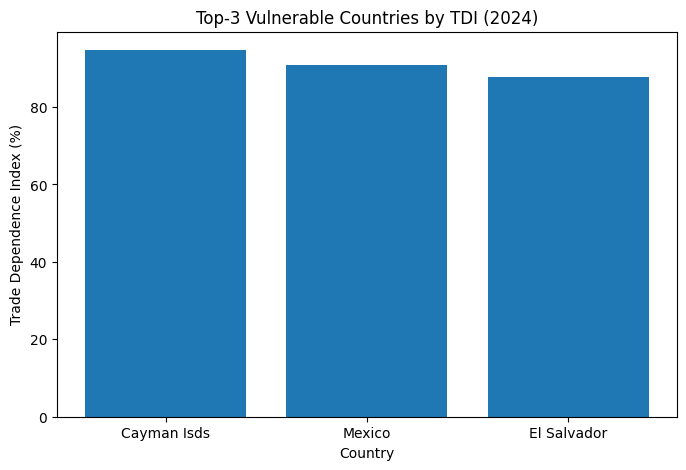

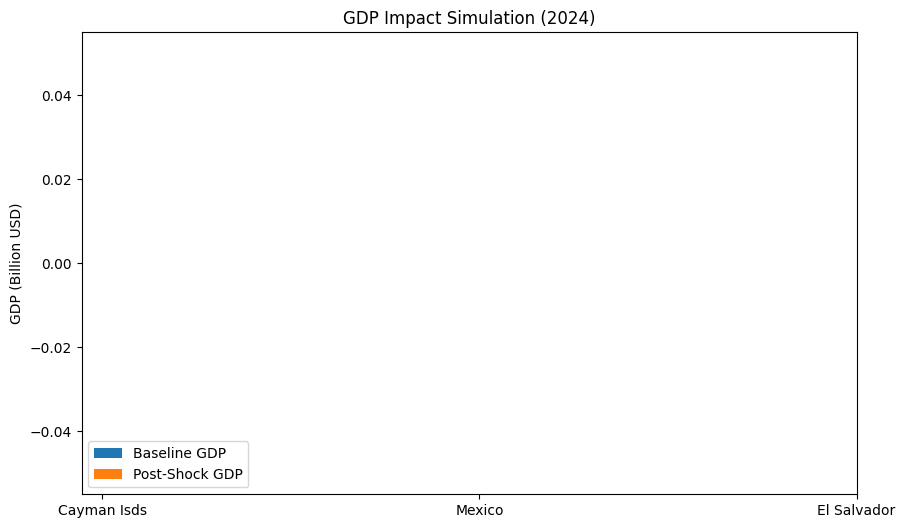

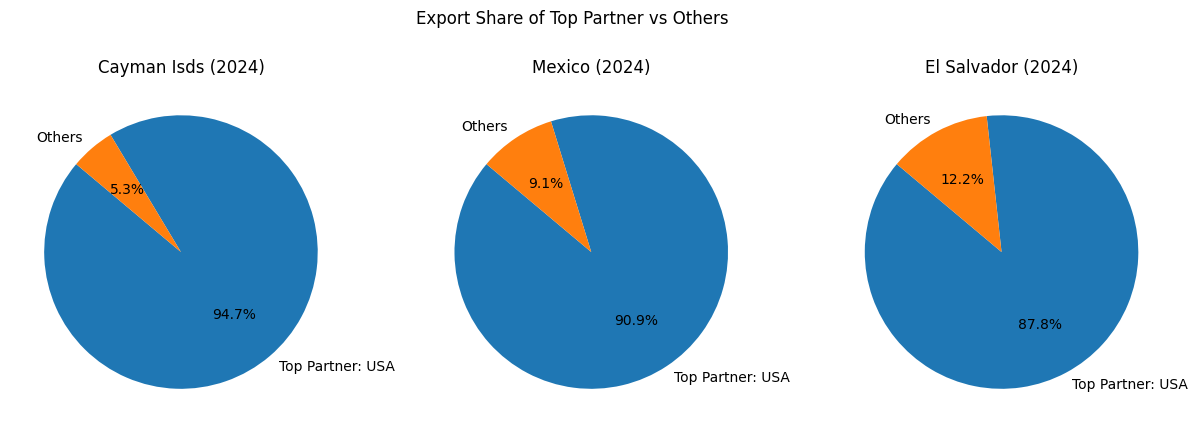

In [16]:
import matplotlib.pyplot as plt

# --- Visualization 1: TDI for Top 3 Vulnerable Countries ---
plt.figure(figsize=(8,5))
plt.bar(top3['Country'], top3['TDI']*100)
plt.title(f"Top-3 Vulnerable Countries by TDI ({latest_trade_year})")
plt.ylabel("Trade Dependence Index (%)")
plt.xlabel("Country")
plt.show()

# --- Visualization 2: GDP Baseline vs New (after trade shock) ---
plt.figure(figsize=(10,6))
x = range(len(sim))
plt.bar(x, sim[f'GDP_{use_year}_Baseline']/1e9, label="Baseline GDP")
plt.bar(x, sim[f'GDP_{use_year}_New']/1e9, label="Post-Shock GDP")
plt.xticks(x, sim['Country'])
plt.title(f"GDP Impact Simulation ({use_year})")
plt.ylabel("GDP (Billion USD)")
plt.legend()
plt.show()

# --- Visualization 3: Trade Partner Share Pie Chart for Top 3 ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))
for i, row in top3.iterrows():
    values = [row['TopPartnerExports'], row['TotalExports'] - row['TopPartnerExports']]
    labels = [f"Top Partner: {row['TopPartner']}", "Others"]
    axes[i].pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f"{row['Country']} ({latest_trade_year})")
plt.suptitle("Export Share of Top Partner vs Others")
plt.show()